In [109]:
"""
Explore dataset to determine correlations, features, etc.
"""

%load_ext autoreload
%autoreload 2

from PDAC_biomarkers.file_utils import read_csv
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# View overall dataset
### Possibly Important Columns:
- `sample_id` - Unique string identifying each subject
- `age` - Patient age in years
- `sex` - Patient sex
- `diagnosis` - 1 = control (no pancreatic disease), 2 = benign hepatobiliary disease (119 of which are chronic pancreatitis); 3 = Pancreatic ductal adenocarcinoma, i.e. pancreatic cancer
- `stage` - cancer stage, mostly NULL
- `benign_sample_diagnosis` - diagnosis for patients with benign diagnosis, mostly NULL
- `creatinine` - creatinine levels, one of the biomarkers
- `LYVE1` - LYVE1 levels, one of the biomarkers
- `REG1B` - REG1B levels, one of the biomarkers
- `TFF1` - TFF1 levels, one of the biomarkers
- `REG1A` - REG1A levels, one of the biomarkers


In [110]:
df = read_csv(Path(r"../data/biomarker_data.csv"))
df

,sample_id,patient_cohort,sample_origin,age,sex,diagnosis,stage,benign_sample_diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,S1,Cohort1,BPTB,33,F,1,NaN,NaN,11.7,1.83222,0.893219,52.948840,654.282174,1262.000
1,S10,Cohort1,BPTB,81,F,1,NaN,NaN,NaN,0.97266,2.037585,94.467030,209.488250,228.407
2,S100,Cohort2,BPTB,51,M,1,NaN,NaN,7.0,0.78039,0.145589,102.366000,461.141000,NaN
3,S101,Cohort2,BPTB,61,M,1,NaN,NaN,8.0,0.70122,0.002805,60.579000,142.950000,NaN
4,S102,Cohort2,BPTB,62,M,1,NaN,NaN,9.0,0.21489,0.000860,65.540000,41.088000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,S549,Cohort2,BPTB,68,M,3,IV,NaN,NaN,0.52026,7.058209,156.241000,525.178000,NaN
586,S558,Cohort2,BPTB,71,F,3,IV,NaN,NaN,0.85956,8.341207,16.915000,245.947000,NaN
587,S560,Cohort2,BPTB,63,M,3,IV,NaN,NaN,1.36851,7.674707,289.701000,537.286000,NaN
588,S583,Cohort2,BPTB,75,F,3,IV,NaN,NaN,1.33458,8.206777,205.930000,722.523000,NaN


# Determine missing data

Check to see if any columns have very low entry values (i.e not NaN or None)

### Cols with missing data
- stage
- benign_sample_diagnosis
- plasma_CA19_9
- REG1A

In [111]:
percentages = (df.count() / df.shape[0])
print(percentages)

mask = percentages < .60 # percentage of each column that is non-empty
print("\nColumns with less than 60% of values present\n")
print(*df.loc[:,mask].columns, sep=", ")

sample_id                  1.000000
patient_cohort             1.000000
sample_origin              1.000000
age                        1.000000
sex                        1.000000
diagnosis                  1.000000
stage                      0.337288
benign_sample_diagnosis    0.352542
plasma_CA19_9              0.593220
creatinine                 1.000000
LYVE1                      1.000000
REG1B                      1.000000
TFF1                       1.000000
REG1A                      0.518644
dtype: float64

Columns with less than 60% of values present

stage, benign_sample_diagnosis, plasma_CA19_9, REG1A


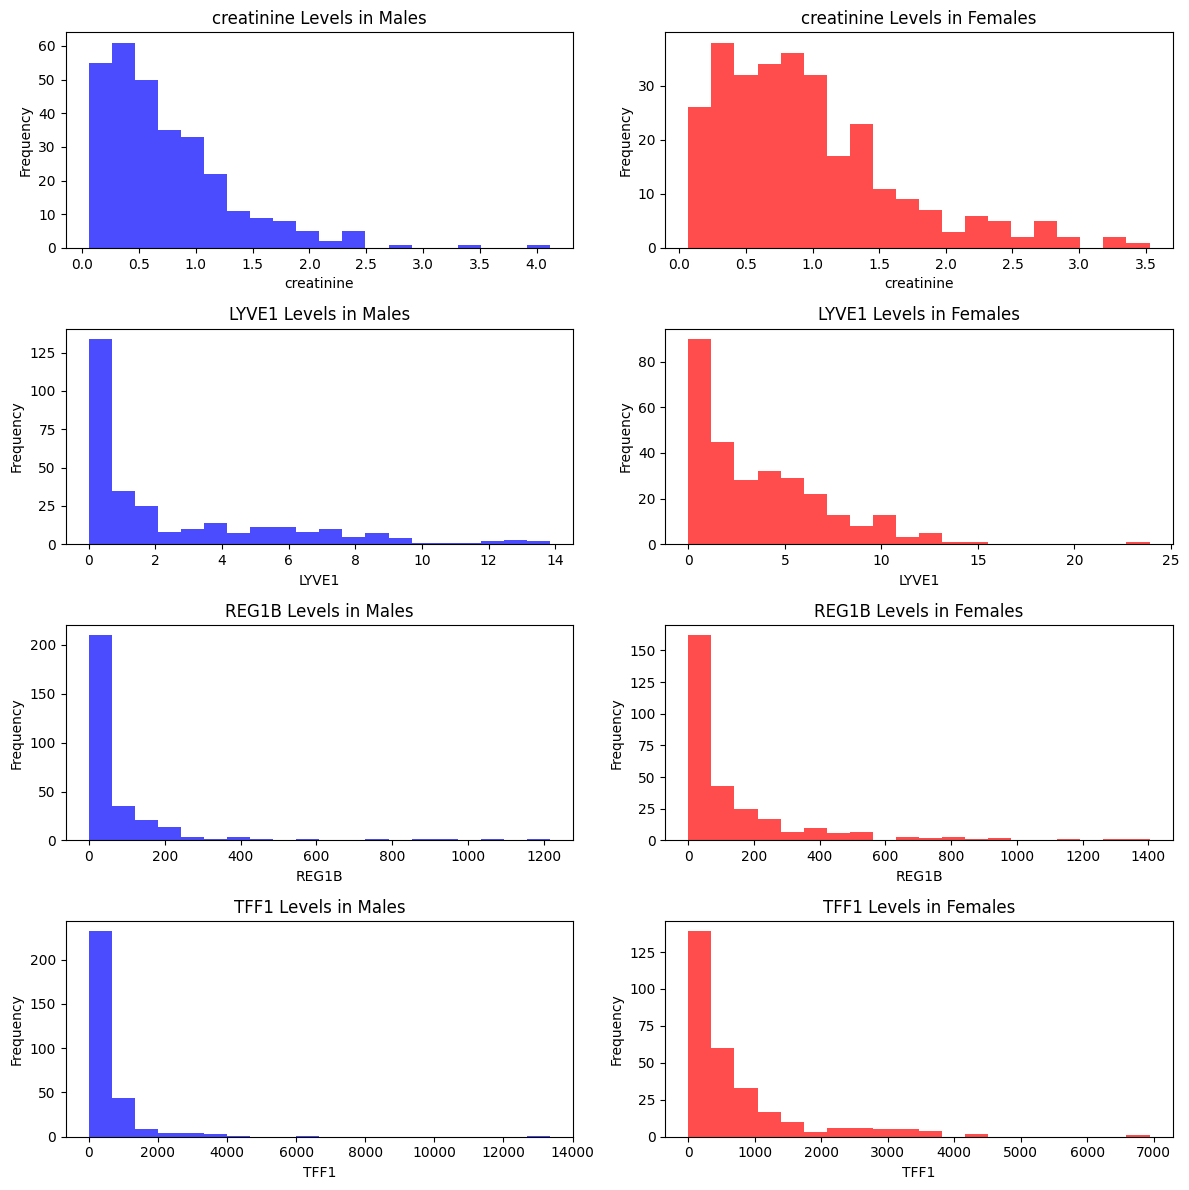

In [172]:
male_data = df.loc[df['sex'] == 'F']
female_data = df.loc[df['sex'] == 'M']

# Plotting histograms of creatinine levels for male and female
plt.figure(figsize=(12,12))

features = ['creatinine', 'LYVE1', 'REG1B', 'TFF1']


for i, feature in enumerate(features):
    # Male data
    plt.subplot(len(features), 2, 2*i+1)
    plt.hist(male_data[feature], bins=20, color='blue', alpha=0.7)
    plt.title(f'{feature} Levels in Males')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

    # Female data
    plt.subplot(len(features), 2, 2*i + 2)
    plt.hist(female_data[feature], bins=20, color='red', alpha=0.7)
    plt.title(f'{feature} Levels in Females')
    plt.xlabel(feature)
    plt.ylabel('Frequency')


plt.tight_layout()
plt.show()

In [173]:
from scipy.stats import ks_2samp

ks_results = {}
for feature in features:
    # Dropping NaN values for a fair comparison
    male_values = male_data[feature].dropna()
    female_values = female_data[feature].dropna()

    # Perform KS test
    ks_stat, p_value = ks_2samp(male_values, female_values)

    # Store the results
    ks_results[feature] = {'KS Statistic': ks_stat, 'p-value': p_value}

ks_results

for feature in ks_results:
    p = feature['p_value']
    if p > 0.05:
        print(f"Difference for {feature} sig. btwn males and females with p={p}")
    else:
        print(f"Difference for {feature} NOT sig. btwn males and females with p={p}")

{'creatinine': {'KS Statistic': 0.1909227781034146,
  'p-value': 3.418321118780307e-05},
 'LYVE1': {'KS Statistic': 0.24860646599777034,
  'p-value': 1.6361074461311627e-08},
 'REG1B': {'KS Statistic': 0.20172625820317439,
  'p-value': 9.540374122181575e-06},
 'TFF1': {'KS Statistic': 0.2074612971071958,
  'p-value': 4.712246041951941e-06}}